<a href="https://colab.research.google.com/github/fekonrad/CombOptLayer/blob/main/Demo/COptLayer_Warcraft_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using the COptLayer
First, let's install the COptLayer repository:

In [1]:
!git clone https://github.com/fekonrad/CombOptLayer.git
!cd CombOptLayer

fatal: destination path 'CombOptLayer' already exists and is not an empty directory.


... and install all necessary libraries:

In [2]:
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

import matplotlib.pyplot as plt
from IPython.display import clear_output

import CombOptLayer
from CombOptLayer import COptLayer
from CombOptLayer.losses import PerturbedLoss

# The Task
This is a short demo on how to use the COptLayer for the toy problem of finding shortest paths on Warcraft maps, only being provided an aerial image of the map, but not the actual costs to traverse a vertex. To illustrate what the maps, graphs and paths look like, see the plots below:


In [3]:
class WarcraftPaths(Dataset):
    def __init__(self, map_path, cost_path, paths_path, num_samples=None):
        super().__init__()
        if num_samples is not None:
          self.maps = torch.tensor(np.load(map_path), dtype=torch.float32).permute(0, 3, 1, 2)[:num_samples]
          self.costs = torch.tensor(np.load(cost_path), dtype=torch.float32)[:num_samples]
          self.shortest_paths = torch.tensor(np.load(paths_path), dtype=torch.float32)[:num_samples]
        else:
          self.maps = torch.tensor(np.load(map_path), dtype=torch.float32).permute(0, 3, 1, 2)
          self.costs = torch.tensor(np.load(cost_path), dtype=torch.float32)
          self.shortest_paths = torch.tensor(np.load(paths_path), dtype=torch.float32)

    def __len__(self):
        return self.maps.shape[0]

    def __getitem__(self, item):
        return self.maps[item], self.costs[item], self.shortest_paths[item]

<ipython-input-4-180c84c6815b>:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[1].legend()


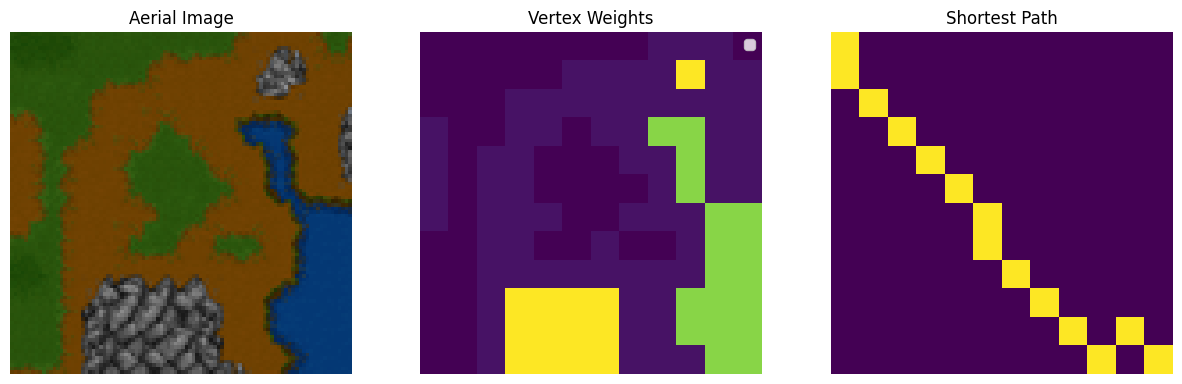

In [4]:
data = WarcraftPaths('/content/train_maps.npy', '/content/train_vertex_weights.npy', '/content/train_shortest_paths.npy')
map, vertex_weights, shortest_path = data[0]

fig, ax = plt.subplots(ncols=3, figsize=(15, 30))
ax[0].imshow(map.permute(1, 2, 0).numpy().astype(np.int32))
ax[0].axis("off")
ax[0].set_title("Aerial Image")
ax[1].imshow(vertex_weights)
ax[1].axis("off")
ax[1].set_title("Vertex Weights")
ax[1].legend()
ax[2].imshow(shortest_path)
ax[2].axis("off")
ax[2].set_title("Shortest Path")
plt.show()

## The Model (CNN)
We implement a very basic CNN to estimate the vertex costs of the map. Since this problem is not very complex, a relatively small model would suffice.

In [5]:
class VertexWeightCNN(nn.Module):
    def __init__(self):
        super().__init__()
        # define architecture ...
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding='same')
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding='same')
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=2, padding='same')
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=2, padding='same')
        self.conv5 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=2, padding='same')
        self.conv6 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=2, padding='same')
        self.final_layer = nn.Conv2d(in_channels=32, out_channels=1, kernel_size=2, padding='same')

    def forward(self, x):
        """
        :param img: torch.tensor of shape (b, c, h, w)      (in our case c=3, h=w=96)
        :return: torch.tensor of shape (b, h', w')      (in our case h'=w'=12)
        """
        x = self.conv1(x)             # (b, 16, 96, 96)
        x = nn.ReLU()(x)
        x = self.conv2(x)               # (b, 32, 96, 96)
        x = nn.ReLU()(x)
        x = nn.MaxPool2d(kernel_size=2)(x)        # (b, 32, 48, 48)

        x = self.conv3(x)             # (b, 32, 48, 48)
        x = nn.ReLU()(x)
        x = self.conv4(x)               # (b, 32, 96, 96)
        x = nn.ReLU()(x)
        x = nn.MaxPool2d(kernel_size=2)(x)        # (b, 32, 24, 24)

        x = self.conv5(x)             # (b, 32, 24, 24)
        x = nn.ReLU()(x)
        x = self.conv6(x)               # (b, 32, 24, 24)
        x = nn.ReLU()(x)
        x = nn.MaxPool2d(kernel_size=2)(x)        # (b, 32, 12, 12)

        return nn.Softplus()(self.final_layer(x)).squeeze(1)  # Softplus to make weights non-negative.

## The Combinatorial Solver (Dijkstra)
Now we just have to implement our solver for finding shortest paths (given vertex weights) on 2D grids, where  the possible moves at each point are up, down, left, right and diagonal.

We have to make sure that the input of our solver is compatible with what our statistical model (the CNN) returns as outputs, i.e. in this case a `torch.tensor` of shape `(b, 1, h, w)`.

**Remark:**
The COptLayer will have to solve multiple instances of the combinatorial problem at once. Therefore it is clever to try to implement the solver using parallelizable operations, instead of trying to solve the problems sequentially. This means either sticking to what `torch` already has implemented or writing your own parallelized methods e.g. using CUDA.

In [6]:

def valid_node(node, size_of_grid):
    """Checks if node is within the grid boundaries."""
    if node[0] < 0 or node[0] >= size_of_grid:
        return False
    if node[1] < 0 or node[1] >= size_of_grid:
        return False
    return True


def up(node):
    return (node[0] - 1, node[1])


def down(node):
    return (node[0] + 1, node[1])


def left(node):
    return (node[0], node[1] - 1)


def right(node):
    return (node[0], node[1] + 1)


def up_left(node):
    return (node[0] - 1, node[1] - 1)


def up_right(node):
    return (node[0] - 1, node[1] + 1)


def down_left(node):
    return (node[0] + 1, node[1] - 1)


def down_right(node):
    return (node[0] + 1, node[1] + 1)


def dijkstra(weights_tens) -> torch.Tensor:
    """
    :param weights: torch.tensor of shape (b, h, w)
    :return: 0-1 torch.tensor of shape (b, h, w) indicating shortest path
    """
    path_matrix_tens = torch.zeros_like(weights_tens)
    for b in range(weights_tens.shape[0]):
        initial_node = [0, 0]
        desired_node = [weights_tens.shape[1] - 1, weights_tens.shape[2] - 1]
        # initialize vertex weights
        weights = torch.clone(weights_tens[b])
        # source and destination are free
        weights[initial_node[0], initial_node[1]] = 0
        weights[desired_node[0], desired_node[1]] = 0

        # initialize maps for distances and visited nodes
        size_of_floor = weights.shape[1]

        # we only want to visit nodes once
        visited = np.zeros([size_of_floor, size_of_floor], bool)

        # store predecessor on current shortest path
        predecessor = np.zeros((size_of_floor, size_of_floor, 2), int)

        # initiate matrix to keep track of distance to source node
        # initial distance to nodes is infinity so we always get a lower actual distance
        distances = np.ones([size_of_floor, size_of_floor]) * np.inf
        # initial node has a distance of 0 to itself
        distances[initial_node[0], initial_node[1]] = 0

        # start algorithm
        current_node = [initial_node[0], initial_node[1]]

        while True:
            directions = [up, down, left, right, up_left, up_right, down_left, down_right]
            for direction in directions:
                potential_node = direction(current_node)
                if valid_node(potential_node, size_of_floor):  # boundary checking
                    if not visited[potential_node[0], potential_node[1]]:  # check if we have visited this node before
                        # update distance to node
                        distance = distances[current_node[0], current_node[1]] + weights[
                            potential_node[0], potential_node[1]]

                        # update distance if it is the shortest discovered
                        if distance < distances[potential_node[0], potential_node[1]]:
                            distances[potential_node[0], potential_node[1]] = distance
                            predecessor[potential_node[0], potential_node[1], 0] = current_node[0]
                            predecessor[potential_node[0], potential_node[1], 1] = current_node[1]

            # mark current node as visited
            visited[current_node[0], current_node[1]] = True

            # select next node by choosing the the shortest path so far
            t = distances.copy()
            # we don't want to visit nodes that have already been visited
            t[np.where(visited)] = np.inf
            # choose the shortest path
            node_index = np.argmin(t)

            # convert index to row,col.
            node_row = node_index // size_of_floor
            node_col = node_index % size_of_floor
            # update current node.
            current_node = (node_row, node_col)

            # stop if we have reached the desired node
            if current_node[0] == desired_node[0] and current_node[1] == desired_node[1]:
                break

        # backtrack to construct path
        path_matrix = torch.zeros(size_of_floor, size_of_floor)
        path_matrix[desired_node[0]][desired_node[1]] = 1
        current = desired_node
        while current != initial_node:
            path_matrix[predecessor[current[0], current[1], 0]][predecessor[current[0], current[1], 1]] = 1
            current = [predecessor[current[0], current[1], 0], predecessor[current[0], current[1], 1]]

        path_matrix_tens[b] = path_matrix
    return path_matrix_tens

torch.Size([8, 12, 12])


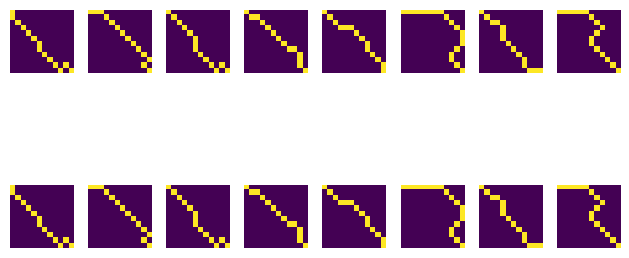

In [7]:
# Quick check that our solver works ...
map, vertex_weights, shortest_path = data[0:8]

solver_output = dijkstra(vertex_weights)
print(solver_output.shape)

fig, ax = plt.subplots(ncols=8, nrows=2)
for i in range(8):
  ax[0,i].imshow(shortest_path[i])
  ax[0,i].axis("off")
  ax[1,i].imshow(solver_output[i].detach().numpy())
  ax[1,i].axis("off")
plt.tight_layout()
plt.show()

Now we have everything we need to build the model!
Here we use the PerturbedLoss with our implemented solver to train the CNN.

*Note:*
Technically, we should require the vertex weights to be non-negative, in order to guarantee convergence of the solver. Thus, one could/should use the "Multiplicative Perturbation discussed in the paper (reference here). Here we simply use the additive perturbation (which might lead to some weights becoming negative!) and the experiments still seem to work fine.

In [18]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = VertexWeightCNN().to(DEVICE)
solver = dijkstra
loss_fn = PerturbedLoss(solver, objective='min', num_samples=10, smoothing=0.3)

The training routine now works like any other training routine in torch!

In [19]:
# We just take 1 training sample here to get faster results ;)
train_data = WarcraftPaths("/content/train_maps.npy",
                     "/content/train_vertex_weights.npy",
                     "/content/train_shortest_paths.npy",
                      num_samples=1)

test_data = WarcraftPaths("/content/test_maps.npy",
                     "/content/test_vertex_weights.npy",
                     "/content/test_shortest_paths.npy",
                      num_samples=1)

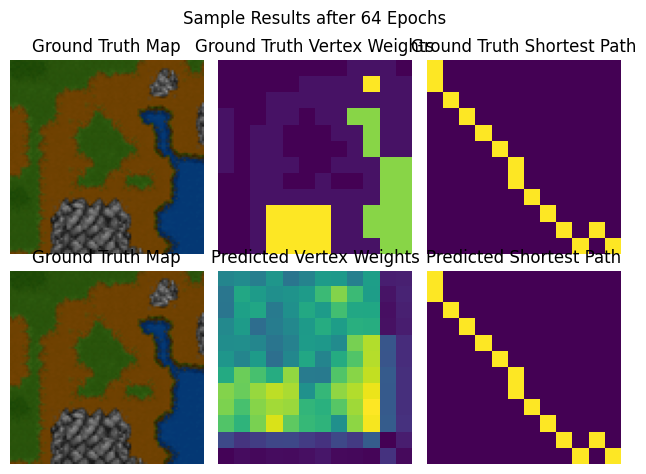

In [20]:
epochs = 64
lr = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


dataloader = DataLoader(train_data, batch_size=16, shuffle=True)
dataloader_test = DataLoader(test_data, batch_size=16, shuffle=False)

test_loss_vals = []

# Sample data point for visualization
sample_map, sample_vertex_weights, sample_shortest_path = train_data[0]

for _ in range(epochs):
    for maps, weights, paths in dataloader:
        maps, weights, paths = maps.to(DEVICE), weights.to(DEVICE), paths.to(DEVICE)

        optimizer.zero_grad()
        vertex_weight_pred = model(maps)
        paths_pred = solver(vertex_weight_pred.squeeze(1))
        loss = loss_fn(vertex_weight_pred, paths)
        loss.backward()
        optimizer.step()

    # Compute Test Loss
    # ...


    # Here we plot a sample prediction for a map after every epoch ...
    weights_pred = model(sample_map.unsqueeze(0))
    paths_pred = solver(weights_pred.squeeze(1))

    clear_output(wait=True)
    fig, ax = plt.subplots(ncols=3, nrows=2)
    # Plot GT
    ax[0, 0].imshow(sample_map.permute(1, 2, 0).numpy().astype(np.int32))
    ax[0, 0].axis("off")
    ax[0, 0].set_title("Ground Truth Map")
    ax[0, 1].imshow(sample_vertex_weights.cpu().detach().numpy())
    ax[0, 1].axis("off")
    ax[0, 1].set_title("Ground Truth Vertex Weights")
    ax[0, 2].imshow(sample_shortest_path.cpu().detach().numpy())
    ax[0, 2].axis("off")
    ax[0, 2].set_title("Ground Truth Shortest Path")

    # Plot Predictions
    ax[1, 0].imshow(sample_map.permute(1, 2, 0).numpy().astype(np.int32))
    ax[1, 0].axis("off")
    ax[1, 0].set_title("Ground Truth Map")
    ax[1, 1].imshow(weights_pred.squeeze(0).cpu().detach().numpy())
    ax[1, 1].axis("off")
    ax[1, 1].set_title("Predicted Vertex Weights")
    ax[1, 2].imshow(paths_pred[0])
    ax[1, 2].axis("off")
    ax[1, 2].set_title("Predicted Shortest Path")
    plt.suptitle(f"Sample Results after {_ + 1} Epochs")
    plt.tight_layout()
    plt.show()
